In [79]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import cv2
from skimage import transform
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils import *
import random

print(tf.__version__)

# Output from the original script (example_physionet.py)
X = np.load("data/X.npy", allow_pickle=True)
Y = np.load("data/Y.npy", allow_pickle=True) # diagnostic superclass

2.3.0


In [56]:
# Raw database and scp statements
df = pd.read_csv("data/ptbxl_database.csv", index_col=0)
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
agg_df = pd.read_csv('data/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

In [6]:
# Select PVC according to scp_codes, control is those with diagnostic superclass "NORM"
label = []
for i in df.index:
    if "PVC" in df.loc[i, "scp_codes"].keys():
        label.append(1)
    elif "PVC" not in df.loc[i, "scp_codes"].keys() and df.loc[i, "diagnostic_superclass"]==['NORM']:
        label.append(0)
    else:
        label.append(-1)
label = np.asarray(label)

In [7]:
X = X[np.where(label!=-1)]
Y = Y[np.where(label!=-1)]
label = label[np.where(label!=-1)]

In [8]:
# Select fold, this time 8
X_test = X[np.where(Y[:,-4]==8)]
X_train = X[np.where(Y[:,-4]!=8)]
Y_test = label[np.where(Y[:,-4]==8)[0]]
Y_train = label[np.where(Y[:,-4]!=8)[0]]

In [11]:
# Model definition
input_layer = tf.keras.layers.Input((1000,12))
x = tf.keras.layers.Conv1D(filters=30, kernel_size=10, padding="causal", activation="relu")(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=30, kernel_size=10, padding="causal", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=20, kernel_size=5, padding="causal", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=20, kernel_size=5, padding="causal", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=10, kernel_size=4, padding="causal", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=10, kernel_size=4, padding="causal", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
gap = tf.keras.layers.GlobalAveragePooling1D()(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(gap)
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [14]:
# Set class weights
counter = Counter(Y_train)
majority = max(counter.values())
lw = {cls: float(majority/count) for cls, count in counter.items()}

In [15]:
epochs = 100
batch_size = 16

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_PVC.h5", save_best_only=True, monitor="val_loss", verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=0.0001
    ),
     tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_crossentropy","accuracy"],
)

In [16]:
scaler = StandardScaler()

num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, (-1, num_features))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, (num_instances, num_time_steps, num_features))

# Use the same scaler as training
num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, (-1, num_features))
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, (num_instances, num_time_steps, num_features))

In [14]:
# Check shape
X_train_scaled.shape, Y_train.shape, X_test_scaled.shape, Y_test.shape

((9055, 1000, 12), (9055,), (993, 1000, 12), (993,))

In [17]:
history = model.fit(
    X_train_scaled,
    Y_train,
    class_weight=lw,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
453/453 [==============================] - ETA: 0s - loss: 0.6288 - binary_crossentropy: 0.4326 - accuracy: 0.8415
Epoch 00001: val_loss improved from inf to 0.22603, saving model to best_model_PVC.h5
453/453 [==============================] - 3s 7ms/step - loss: 0.6288 - binary_crossentropy: 0.4326 - accuracy: 0.8415 - val_loss: 0.2260 - val_binary_crossentropy: 0.2260 - val_accuracy: 0.9608
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 0.4080 - binary_crossentropy: 0.2335 - accuracy: 0.9293
Epoch 00002: val_loss improved from 0.22603 to 0.13054, saving model to best_model_PVC.h5
453/453 [==============================] - 3s 6ms/step - loss: 0.4080 - binary_crossentropy: 0.2335 - accuracy: 0.9293 - val_loss: 0.1305 - val_binary_crossentropy: 0.1305 - val_accuracy: 0.9663
Epoch 3/100
444/453 [============================>.] - ETA: 0s - loss: 0.3128 - binary_crossentropy: 0.1693 - accuracy: 0.9575
Epoch 00003: val_loss did not improve from 0.13054
45

In [18]:
model = tf.keras.models.load_model("best_model_PVC.h5")

In [25]:
model.evaluate(X_test_scaled, Y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0295 - binary_crossentropy: 0.0295 - accuracy: 0.9909


[0.029452601447701454, 0.029452601447701454, 0.9909365773200989]

In [26]:
Y_pred = model(X_test_scaled).numpy()

In [27]:
Y_pred_label = (model.predict(X_test_scaled)>0.5).astype("int")[:,0]

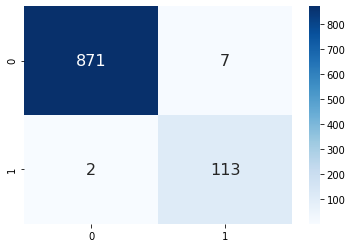

In [32]:
heatmap = sns.heatmap(pd.DataFrame(confusion_matrix(Y_test, Y_pred_label)), annot_kws={"size": 16}, annot=True, cmap='Blues', fmt='g')
plt.savefig("images/cm.png")

In [128]:
# fetch Top-50 probability and pick random number
top50 = np.argsort(-Y_pred.squeeze())[0:50]
N=top50[random.randint(0,50)]
test_array = X_test_scaled[N]
cam_input = np.expand_dims(test_array, 0)
prediction = model(cam_input).numpy()

In [129]:
# Score-CAM
## The implementation was derived from https://github.com/tabayashi0117/Score-CAM and modified under MIT license

act_map_model = Model(inputs=model.input, outputs=model.get_layer([i.name for i in model.layers if "conv" in i.name][-1]).output)
act_map_array = act_map_model(cam_input)
act_map_resized_list = [
    transform.resize(act_map_array[0,:,k], (1000,1)) for k in range(act_map_array.shape[2])
]

act_map_normalized_list = []
for act_map_resized in act_map_resized_list:
    if np.max(act_map_resized) - np.min(act_map_resized) != 0:
        act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
    else:
        act_map_normalized = act_map_resized
    act_map_normalized_list.append(act_map_normalized)
        
masked_input_list = []
for act_map_normalized in act_map_normalized_list:
    masked_input = np.copy(cam_input).astype("float64")
    for k in range(cam_input.shape[2]):
        masked_input[0,:,k] *= np.squeeze(act_map_normalized)
    masked_input_list.append(masked_input)
masked_input_array = np.concatenate(masked_input_list, axis=0)
weight = model.predict(masked_input_array)

cam = np.dot(act_map_array[0,:,:], weight)
cam = transform.resize(cam, (1000,))
cam = np.maximum(0, cam)
cam /= np.max(cam)

In [130]:
cam_90 = cam.squeeze().copy()
q_90 = np.quantile(cam_90, 0.9)
cam_90 = (cam_90>q_90).astype("int")

In [140]:
raw_input = X_test[N]
# Specify time interval and channel to visualize
S=0
E=400
C=8
title="Correct class: "+str(Y_test[N])+", Prediction probability: "+str(prediction[0][0])+", Time interval: "+str(S)+" to "+str(E)+", Channel: "+str(C)

In [141]:
fig = go.Figure([
    go.Scatter(x=np.arange(S,E,1), y=raw_input[:,C].T.squeeze()[S:E],
                    mode='lines',
                    name='Raw signal'),
    
    go.Scatter(x=np.arange(S,E,1),
                         y=cam.squeeze()[S:E],
                         marker=dict(size=4),
                    mode='lines+markers',
                    name='Raw CAM',
)])

cam90Pos = returnPos(np.where(cam_90==1)[0][(np.where(cam_90==1)[0]<=E) & (np.where(cam_90==1)[0]>=S)])
shapeDic = []
for i in cam90Pos:
    shapeDic.append(
        dict(type="rect",xref="x", yref="y", x0=i[0], x1=i[1],
         y0=np.min(raw_input.squeeze()), y1=max(np.max(raw_input), np.max(cam.flatten())),
         fillcolor="pink", opacity=0.5, line_width=0,layer="below")
    )

fig["layout"]["shapes"]=shapeDic
fig.update_layout(
    title=title,
    font=dict(size=20),
    width=1600,
    height=700,
    yaxis_range=[-1,1],
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

In [142]:
fig.write_image("images/ecg_cam.png")